In [1]:
#Import Libraries
import numpy as np
import glob
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import h5py
import math

In [64]:
# Functions used in plotting 

# Function to get simulation details from 
def get_sim_details(df_in, casename, gn):
    
    # Get row id base on simulation name
    id_row = np.where(df_in['Unique Identifier']==casename)[0] 

    # extract data from that row
    row_data = sim_sheet.iloc[id_row]

    if gn == 1:
        cenlat = row_data['Lat']
        cenlon = row_data['Lon']
        nx = row_data['Nx'] 
        ny = row_data['Ny'] 
        m = row_data['dx = dy (m)']
    elif gn == 2:
        cenlat = row_data['Lat.1']
        cenlon = row_data['Lon.1']
        nx = row_data['Nx.1'] 
        ny = row_data['Ny.1'] 
        m = row_data['dx = dy (m).1']
    elif gn == 3:
        cenlat = row_data['Lat.2']
        cenlon = row_data['Lon.2']
        nx = row_data['Nx.2'] 
        ny = row_data['Ny.2'] 
        m = row_data['Spacing']
    else:
        print('Error: bad grid number input')
        
    return cenlat.to_numpy()[0], cenlon.to_numpy()[0], nx.to_numpy()[0]*m.to_numpy()[0]/2, ny.to_numpy()[0]*m.to_numpy()[0]/2
                    
def domain_box_from_center(cen_lat,cen_lon,dx,dy):
    # Function to make a box based on center lat, center lon, and length of box sides
    #
    # Inputs:
    # cen_lat: center latitude of box
    # cen_lon: center longitude of box
    # dx: 0.5 * length of E-W side of box (m)
    # dy: 0.5 * length of N-S side of box (m)
    #
    # Output: 
    # Nlat: latitudes of 4 corners of the box
    # Nlon: longitude of 4 corners of the box 
    factors = [[1,-1],[1,1],[-1,1],[-1,-1]] # account for direction for each line of the box
    Nlon = np.zeros(4)
    Nlat = np.zeros(4)
    
    # loop through four corners
    for i in np.arange(0,4):
        # Calculate distance from center of the box corner in m
        dy_adj = dy * factors[i][0]
        dx_adj = dx * factors[i][1]
        d = np.sqrt( dx_adj*dx_adj + dy_adj*dy_adj) 
        R = 6378140 # Radius of the Earth in m

        lat1 = cen_lat * (np.pi/180) # convert to radians
        lon1 = (cen_lon+180) * (np.pi/180) # convert to radians

        # Using haversine formula to estimate lat and lon of corner based on distance and center lat/lon
        bearing = (90 - math.degrees(math.atan2(dy_adj,dx_adj))) % 360
        bearing_rad = bearing * (np.pi/180)
        lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(bearing_rad) )
        lon2 = lon1 + math.atan2( math.sin(bearing_rad)*math.sin(d/R)*math.cos(lat1), math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

        # Convert to latitude/longtiude
        Nlat[i] = lat2 * (180/np.pi)
        Nlon[i] = lon2 * (180/np.pi) - 180

    return Nlat,Nlon

def plot_domain_boxes(ax,lat_p,lon_p,name,color):
    # Function to plot a box in python
    #
    # Inputs:
    # ax: plotting axis
    # lat_p: dictionary of corner lats associated with each simulation
    # lon_p: dictionary of corner lons associated with each simulation
    # name: name of current simulation to plot
    # color: color to make lines

    # Calculating bounding lat/lons of box
    #print([lon_p[name], lat_p[name]])
    lon_pmax = np.nanmax(lon_p[name])
    lon_pmin = np.nanmin(lon_p[name])
    lat_pmax = np.nanmax(lat_p[name])
    lat_pmin = np.nanmin(lat_p[name])

    # Plot 4 lines to create box
    ax.plot([lon_pmax, lon_pmax], [lat_pmin, lat_pmax],lw=2,ls='-', color=color, transform=ccrs.Geodetic())
    ax.plot([lon_pmin, lon_pmin], [lat_pmin, lat_pmax],lw=2,ls='-', color=color, transform=ccrs.Geodetic())
    ax.plot([lon_pmin, lon_pmax], [lat_pmin, lat_pmin],lw=2,ls='-', color=color, transform=ccrs.Geodetic())
    ax.plot([lon_pmin, lon_pmax], [lat_pmax, lat_pmax],lw=2,ls='-', color=color, transform=ccrs.Geodetic())
    
    return()

def read_head(headfile,h5file):
    
    # Function that reads header files from RAMS
    
    # Inputs:
    #   headfile: header file including full path in str format
    #   h5file: h5 datafile including full path in str format
    
    # Returns:
    #   zmn: height levels for momentum values (i.e., grid box upper and lower levels)
    #   ztn: height levels for thermodynaic values (i.e., grid box centers)
    #   nx:: the number of x points for the domain associated with the h5file
    #   ny: the number of y points for the domain associated with the h5file
    #   npa: the number of surface patches
    
    
    dom_num = h5file[h5file.index('.h5')-1] # Find index of .h5 to determine position showing which nest domain to use

    with open(headfile) as f:
        contents = f.readlines()
        
    idx_zmn = contents.index('__zmn0'+dom_num+'\n')
    nz_m = int(contents[idx_zmn+1])
    zmn = np.zeros(nz_m)
    for i in np.arange(0,nz_m):
        zmn[i] =  float(contents[idx_zmn+2+i])
    
    idx_ztn = contents.index('__ztn0'+dom_num+'\n')
    nz_t = int(contents[idx_ztn+1])
    ztn = np.zeros(nz_t)
    for i in np.arange(0,nz_t):
        ztn[i] =  float(contents[idx_ztn+2+i])
    
    ztop = np.max(ztn) # Model domain top (m)
    
    # Grad the size of the horizontal grid spacing
    idx_dxy = contents.index('__deltaxn\n')
    dxy = float(contents[idx_dxy+1+int(dom_num)].strip())

    idx_npatch = contents.index('__npatch\n')
    npa = int(contents[idx_npatch+2])
    
    idx_ny = contents.index('__nnyp\n')
    idx_nx = contents.index('__nnxp\n')
    ny = np.ones(int(contents[idx_ny+1]))
    nx = np.ones(int(contents[idx_ny+1]))
    for i in np.arange(0,len(ny)):
        nx[i] = int(contents[idx_nx+2+i])
        ny[i] = int(contents[idx_ny+2+i])

    ny_out = ny[int(dom_num)-1]
    nx_out = nx[int(dom_num)-1]

    return zmn, ztn, nx_out, ny_out, dxy, npa 
    

In [65]:
# INCUS Simulation tracking spreadsheet
filein = '/home/pmarin/INCUS/INCUS Phase B Coordination and Schedule_231004.xlsx'
 
# read by default 1st sheet of an excel file
sim_sheet = pd.read_excel(filein,skiprows=14)

In [66]:
# Define lat lon dicrionaries
lat_p1 = OrderedDict()
lon_p1 = OrderedDict()
lat_p2 = OrderedDict()
lon_p2 = OrderedDict()
lat_p3 = OrderedDict()
lon_p3 = OrderedDict()
hfilenames = OrderedDict()

# Path for saving filename
savepath = '/home/pmarin/INCUS/Code/Simulation_Domains/'

cases = ['ARG1.1-R','ARG1.2-R','BRA1.1-R','BRA1.2-R','AUS1.1-R','AUS1.1-R','DRC1.1-R','PHI1.1-R','PHI1.1-RPR',
         'PHI2.1-R','WPO1.1-R','WPO1.1-R','USA1.1-R','USA1.1-R','RSA1.1-R','DRC1.1-RCR','BRA1.1-RPR']

scases = ['ARG1.1-R','ARG1.2-R','BRA1.1-R','BRA1.2-R','AUS1.1-R','AUS1.1-W','DRC1.1-R','PHI1.1-R','PHI1.1-RPR',
         'PHI2.1-R','WPO1.1-R','WPO1.1-W','USA1.1-R','USA1.1-W','RSA1.1-R','DRC1.1-RCR','BRA1.1-RPR']

pcases = ['DRC1.1-R','WPO1.1-R','BRA1.2-R','AUS1.1-R']
pcases = ['BRA1.2-R','DRC1.1-R','AUS1.1-R','WPO1.1-R']

for p in np.arange(0,len(pcases)):
    cn = pcases[p]
    hfilenames[cn] = sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+cn+'-V0/G3/out_30s/a-A*g3.h5'))[0]

for c in np.arange(0,len(cases)):
    casename = cases[c]
    sname = scases[c]
    # Get Grid 3
    inval = get_sim_details(sim_sheet,casename,3)
    lat_p3[sname],lon_p3[sname] = domain_box_from_center(inval[0],inval[1],inval[2],inval[3])

    # Get Grid 2 (# Comment out to skip Grid 2 for clarity)
    #inval = get_sim_details(sim_sheet,casename,2)
    #lat_p2[sname],lon_p2[sname] = domain_box_from_center(inval[0],inval[1],inval[2],inval[3])
    
    # Get Grid 1   
    inval = get_sim_details(sim_sheet,casename,1)
    lat_p1[sname],lon_p1[sname] = domain_box_from_center(inval[0],inval[1],inval[2],inval[3])
    

In [67]:
# Grab model vertical levels from a headerfile
headfile = '/monsoon/MODEL/LES_MODEL_DATA/V0/BRA1.1-R-V0/G3/out_30s/a-L-2014-03-31-183000-head.txt'
h5file = '/monsoon/MODEL/LES_MODEL_DATA/V0/BRA1.1-R-V0/G3/out_30s/a-L-2014-03-31-183000-g3.h5'
zmn, ztn, nx_out, ny_out, dxy, npa = read_head(headfile,h5file)

0.9108678655199375
0.700374531835206
1.1362397820163488
0.8106402164111812
[array([114.30978321, 123.19021679, 123.02634075, 114.47365925]), array([20.24363252, 20.24363252, 13.06517469, 13.06517469])]
[array([118.46094916, 120.03905084, 120.03233648, 118.46766352]), array([18.08446704, 18.08446704, 16.51247401, 16.51247401])]
[array([23.12547472, 34.07452528, 34.57126891, 22.62873109]), array([-21.40299821, -21.40299821, -31.36913493, -31.36913493])]
[array([28.75205917, 31.74794083, 31.77607181, 28.72392819]), array([-24.70012496, -24.70012496, -26.90423684, -26.90423684])]
[array([-67.99156327, -48.00843673, -47.8942815 , -68.1057185 ]), array([ 4.988354  ,  4.988354  , -9.91175143, -9.91175143])]
[array([-60.79820537, -58.70179463, -58.69851781, -60.80148219]), array([-3.30037635, -3.30037635, -5.59813565, -5.59813565])]
[array([114.30978321, 123.19021679, 123.02634075, 114.47365925]), array([20.24363252, 20.24363252, 13.06517469, 13.06517469])]
[array([118.46094916, 120.03905084, 

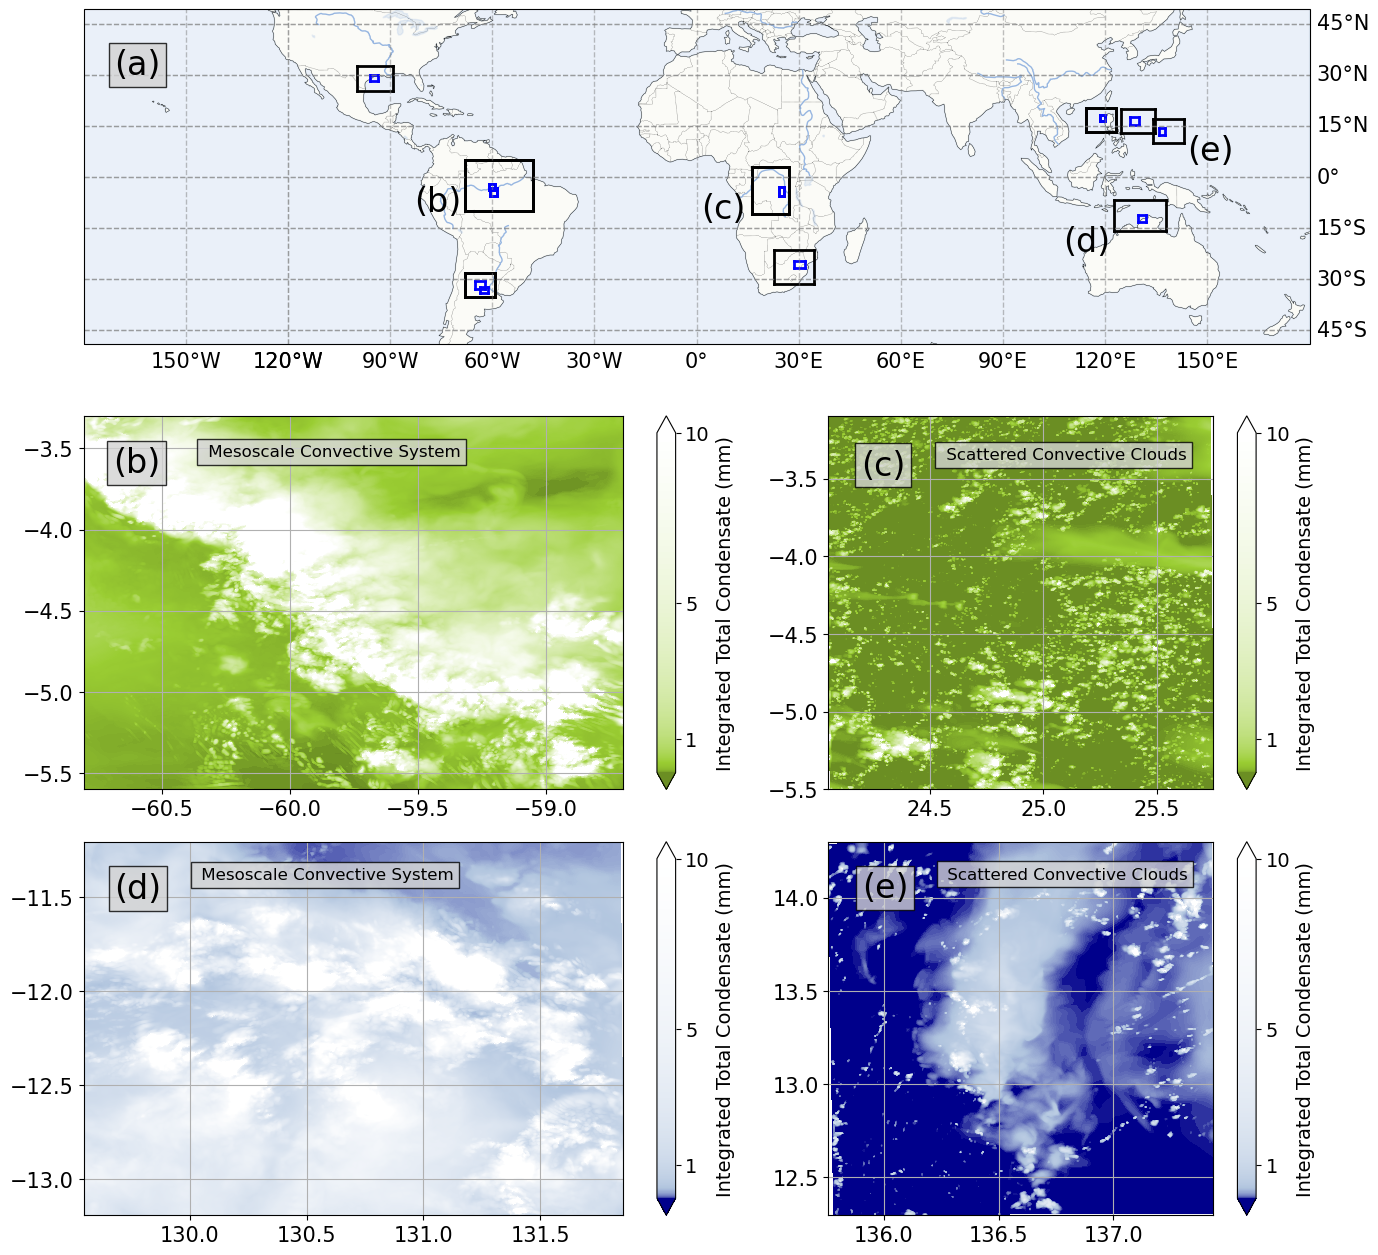

In [69]:
# Make plot of all simulations domains on global map (Figure 1 of manuscript)

axm = OrderedDict()
fig = plt.figure(figsize=(14, 13))
plt.rcParams.update({'font.size': 15})
# Calculate ratio of nx to ny for each of the simulation for defining the subplot width
nx_ny = OrderedDict()
for p in np.arange(0,len(pcases)):
    cn = pcases[p]
    inval = get_sim_details(sim_sheet,cn,3)
    nx_ny[p] = inval[2]/inval[3]
    print(nx_ny[p])

#gs = GridSpec(2, 4, width_ratios=[nx_ny[0], nx_ny[1], nx_ny[2], nx_ny[3]], height_ratios=[1.5, 1])
#gs = GridSpec(3, 5, width_ratios=[nx_ny[0], nx_ny[1], nx_ny[2], nx_ny[3]], height_ratios=[1.5, 1])
gs = GridSpec(3, 2, width_ratios=[nx_ny[2], nx_ny[3]], height_ratios=[1, 1, 1])
ax = fig.add_subplot(gs[0,0:5],projection=ccrs.PlateCarree())
axm[0] = fig.add_subplot(gs[1,0])
axm[1] = fig.add_subplot(gs[1,1])
axm[2] = fig.add_subplot(gs[2,0])
axm[3] = fig.add_subplot(gs[2,1])

yticks = OrderedDict()
yticks[0] = np.arange(-5.5,-3.4,0.5)
yticks[1] = np.arange(-5.5,-3.4,0.5)
yticks[2] = np.arange(-13,-11.1,0.5)
yticks[3] = np.arange(12.5,14.1,0.5)

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

#ax.stock_img()
#ax.coastlines()
#ax.add_feature(cfeature.BORDERS)

ax.add_feature(cfeature.LAND, alpha=0.2)
ax.add_feature(cfeature.OCEAN, alpha=0.2)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cfeature.LAKES, alpha=0.2)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-120, 120, -30, 30])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlines = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,180.1,30))
gl.xlocator = mticker.FixedLocator([-150,-120,-90,-60,-30,0,30,60,90,120,150])
#gl.xlocator = mticker.FixedLocator([-120])
gl.xformatter = LONGITUDE_FORMATTER
#gl.ylocator = mticker.FixedLocator([-45, -30, -23.4,-15,0,15, 23.4, 30, 45])
gl.ylocator = mticker.FixedLocator([-45, -30,-15,0,15, 30, 45])
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl2.ylabels_left = False
gl2.ylabels_right = False
gl2.ylocator = mticker.FixedLocator([-45, -30,-15,0,15, 30, 45])
gl2.xlocator = mticker.FixedLocator([-120])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.xlabel_style = {'size': 15, 'color': 'black'}

com_list = ['PHI1.1-R','RSA1.1-R','BRA1.2-R','PHI1.1-RPR','PHI2.1-R','ARG1.1-R','ARG1.2-R','BRA1.1-R',
            'BRA1.1-RPR','BRA1.2-R','DRC1.1-R','DRC1.1-RCR','AUS1.1-R','USA1.1-R','WPO1.1-R']

for i in np.arange(0,len(com_list)):
    plot_domain_boxes(ax,lat_p1,lon_p1,com_list[i],'black')
#    plot_domain_boxes(ax,lat_p2,lon_p2,com_list[i],'gray') # Comment out Grid 2
    plot_domain_boxes(ax,lat_p3,lon_p3,com_list[i],'blue')

    
pfsize = 24 # fontsize for panel labels
panellabels = ('(b)','(c)','(d)','(e)')
panellabelsmode = (' Mesoscale Convective System',' Scattered Convective Clouds',' Mesoscale Convective System',' Scattered Convective Clouds')
for p in np.arange(0,len(pcases)):
    cn = pcases[p]
    dx = 15; dy = 15
    if p == 3:
        dx = -10; dy = 12
    ax.text(lon_p1[cn][0]-dx,lat_p1[cn][0]-dy,panellabels[p],fontsize=pfsize)
ax.text(-171,30,'(a)',fontsize=pfsize,bbox=dict(facecolor='lightgray',alpha=0.8))
    
plot_ind = 1
if plot_ind == 1:
    w_lvls = np.arange(0,40.1,1)
    for p in np.arange(0,len(pcases)):
        cn = pcases[p]
        print('Plotting '+cn)
        rams_file = h5py.File(hfilenames[cn], 'r')
        lat = rams_file['GLAT'][:]
        lon = rams_file['GLON'][:]

        cp = 1004; # J/kg/K
        rd = 287; # J/kg/K
        p00 = 100000; # Reference Pressure

        th = rams_file['THETA'][0,:,:]
        
        # Load variables needed to calculate density
        th = rams_file['THETA'][:]
        pi = rams_file['PI'][:]
        rv = rams_file['RV'][:]
        nx = np.shape(th)[2]
        ny = np.shape(th)[1]
        # Convert RAMS native variables to temperature and pressure
        pres = np.power((pi/cp),cp/rd)*p00
        temp = th*(pi/cp)
        del(th,pi)    
        # Calculate atmospheric density
        dens = pres/(rd*temp*(1+0.61*rv))
        del(pres,temp,rv)

        # Calculate total condensate (kg/kg)
        rtp = rams_file['RTP'][:]-rams_file['RV'][:] 

        # Difference in heights (dz)    
        diff_zt_3D = np.tile(np.diff(ztn),(int(ny),int(nx),1))
        diff_zt_3D = np.moveaxis(diff_zt_3D,2,0)  

        # Calculate integrated total condenste
        itc = np.nansum(rtp[1:,:,:]*dens[1:,:,:]*diff_zt_3D,axis=0) # integrated total condensate in kg
        itc_mm = itc/997*1000 # integrated total condensate in mm
        itc_mm[itc_mm<=0] = 0.001
        del(rtp,dens,diff_zt_3D)

        # Make new colorbar to blue (no condensate) to white (condensate)
        from matplotlib.colors import LinearSegmentedColormap
        if cn == 'WPO1.1-R' or cn == 'AUS1.1-R':
            colorlist=["darkblue", "lightsteelblue", "white"]
            newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)
        elif cn == 'DRC1.1-R' or cn == 'BRA1.2-R':
            colorlist=["olivedrab", "yellowgreen", "white"]
            newcmp = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=256)

        #pltvar = np.nanmax(rams_file['WP'][:],axis=0)
        itc_lvls = np.arange(0.01,10.01,0.01) # Adjusted these levels, such that figure shows regions with at least 1 grid box with 0.1 g/kg of condensate
        itc_cbar_ticks = np.log10(np.array([1,5,10]))
        itc_cbar_ticklbls = np.array([1,5,10])

        a = axm[p].contourf(lon,lat,np.log10(itc_mm),levels=np.log10(itc_lvls),cmap=newcmp,extend='both')

        # Plot colorbar
        cbar = plt.colorbar(a,ax=axm[p],ticks=itc_cbar_ticks)
        cbar.ax.set_yticklabels(itc_cbar_ticklbls,fontsize=14)
        cbar.ax.set_ylabel('Integrated Total Condensate (mm)',fontsize=14)

        #a = axm[p].contourf(lon,lat,th,levels=np.arange(290,310.1,2),cmap=newcmp,extend='both')
        #cbar = plt.colorbar(a,ax=axm[p])
        #cbar.ax.set_ylabel('Integrated Total Condensate (mm)',fontsize=15)
        
        axm[p].set_yticks(yticks[p])
        
        axm[p].grid()
        # Add text labels for panels (b-e)
        dlat_arr = [0.35,0.38,0.3,0.3]
        dlon_arr = [0.05,0.07,0.00,0.04]
        axm[p].text(np.min(lon)+0.15/nx_ny[p]-dlon_arr[p],np.max(lat)-dlat_arr[p],panellabels[p],fontsize=pfsize,bbox=dict(facecolor='lightgray',alpha=0.8))
        axm[p].text(np.min(lon)+0.15/nx_ny[p]-dlon_arr[p]+0.35,np.max(lat)-dlat_arr[p]+0.1,panellabelsmode[p],fontsize=pfsize-12,bbox=dict(facecolor='lightgray',alpha=0.8))
        rams_file.close() # Close RAMS file
    
plt.tight_layout()
plt.savefig('/tempest/pmarin/monsoon/ENV/Plots/Figure01.png')
plt.savefig('/tempest/pmarin/monsoon/ENV/Plots/Figure01.pdf')
